In [5]:
#Again we use the "!" command to specify we want to execute commands via the terminal, outside python
#rootls is an example of a root command line tool: 
#https://root.cern/manual/storing_root_objects/#root-command-line-tools
#Allows to run common operations from the linux/mac terminal, without running ROOT or python directly.
! rootls ../Lecture1/tree2.root

t2


In [6]:
#To do the same in python we would have to type:
from ROOT import TFile
myFile = TFile.Open("../Lecture1/tree2.root")
#Note the output is a bit more detailed though
myFile.ls()

TFile**		../Lecture1/tree2.root	
 TFile*		../Lecture1/tree2.root	
  KEY: TTree	t2;1	a Tree with data from a fake Geant3


In [1]:
#"make" is a standard command to build an executable, which you can run. An executable can be thought of as a 
#translation of your computer code into something the computer can understand. When using python this happens in
#real time, behind the scenes.
#The "!" tells Jupyter to run the command in the underlying terminal.
! make 
#You can see the commands "make" actually runs printed below.
#Lots of options passed to g++ (don't worry about these) - the important part is it creates library files (*.d,*.o)
#and eventually an executable which you run ("myROOTCommand")

g++  -std=c++11 -g -Wall -I -stdlib=libc++ -pthread -std=c++17 -m64 -I/opt/hep/root/6.28.04/include -o myROOTCommand.d -MM -MT 'myROOTCommand.o myROOTCommand.d' myROOTCommand.c
clang: warning: treating 'c' input as 'c++' when in C++ mode, this behavior is deprecated [-Wdeprecated]
g++  -std=c++11 -g -Wall -I -stdlib=libc++ -pthread -std=c++17 -m64 -I/opt/hep/root/6.28.04/include -o myROOTCommand.o -c myROOTCommand.c
clang: warning: treating 'c' input as 'c++' when in C++ mode, this behavior is deprecated [-Wdeprecated]
g++ -Wl,-rpath,/opt/hep/root/6.28.04/lib  -g -Wall -o myROOTCommand myROOTCommand.o  `root-config --libs` -lvectorDict


In [2]:
#Run the command in the terminal, and we see what it does.
! ./myROOTCommand ../Lecture1/tree2.root t2

***********************************************************************************************************
*    Row   * Instance * vect.vect * getot.get * gekin.gek * nmec.nmec * lmec.lmec * destep.de *   pid.pid *
***********************************************************************************************************
*        0 *        0 *         0 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        1 *         0 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        2 *         0 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        3 * 0.7449554 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        4 * -0.324226 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        5 * 0.5830255 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        6 * -0.0

In [3]:
#We can also make a python shortcut command!
#Note in linux you can skip the "python3" part (needed in Jupyter on mybinder!)
! python3 ./myROOTCommand.py ../Lecture1/tree2.root t2

***********************************************************************************************************
*    Row   * Instance * vect.vect * getot.get * gekin.gek * nmec.nmec * lmec.lmec * destep.de *   pid.pid *
***********************************************************************************************************
*        0 *        0 *         0 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        1 *         0 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        2 *         0 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        3 * 0.7449554 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        4 * -0.324226 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        5 * 0.5830255 * 0.1396002 * 0.0026002 *         0 *           *         0 *         1 *
*        0 *        6 * -0.0

In [4]:
#Task 1
#Make your own python shortcut command which draws an arbitrary variable from the TTree in tree2.root

In [1]:
#Now lets use uproot - note there is no c++ version! Python only.
import uproot
#Load the TTree from the ATLAS open data (note the miniTree variable is NOT of type TTree - we are now
#in the uproot ecosystem and not in the ROOT ecosystem
miniTreeZmumu = uproot.open("http://opendata.atlas.cern/release/samples/MC/mc_147771.Zmumu.root")["mini"]
#Lets print the variables in the TTree
miniTreeZmumu.keys()
#note these variables are defined at http://opendata.atlas.cern/books/current/openatlasdatatools/_book/variable_names.html

['runNumber',
 'eventNumber',
 'channelNumber',
 'mcWeight',
 'pvxp_n',
 'vxp_z',
 'scaleFactor_PILEUP',
 'scaleFactor_ELE',
 'scaleFactor_MUON',
 'scaleFactor_BTAG',
 'scaleFactor_TRIGGER',
 'scaleFactor_JVFSF',
 'scaleFactor_ZVERTEX',
 'trigE',
 'trigM',
 'passGRL',
 'hasGoodVertex',
 'lep_n',
 'lep_truthMatched',
 'lep_trigMatched',
 'lep_pt',
 'lep_eta',
 'lep_phi',
 'lep_E',
 'lep_z0',
 'lep_charge',
 'lep_type',
 'lep_flag',
 'lep_ptcone30',
 'lep_etcone20',
 'lep_trackd0pvunbiased',
 'lep_tracksigd0pvunbiased',
 'met_et',
 'met_phi',
 'jet_n',
 'alljet_n',
 'jet_pt',
 'jet_eta',
 'jet_phi',
 'jet_E',
 'jet_m',
 'jet_jvf',
 'jet_trueflav',
 'jet_truthMatched',
 'jet_SV0',
 'jet_MV1']

In [3]:
#choose which variables we want to use
#For each event with jets, we get an array of size alljet_n (NOT jet_N!)
#entry_stop restricts the number of entries to use (just done to make example run faster...)
#library set to 'pd' gives us a pandas dataframe
df_Zmumu = miniTreeZmumu.arrays(["alljet_n","jet_pt"],library='pd',entry_stop=1000)
df_Zmumu

,alljet_n,jet_pt
0,0,[]
1,0,[]
2,0,[]
3,0,[]
4,1,[43057.7421875]
...,...,...
995,2,"[27620.248046875, 33358.140625]"
996,0,[]
997,1,[27622.818359375]
998,1,[29251.833984375]


array([[<AxesSubplot: title={'center': 'alljet_n'}>]], dtype=object)

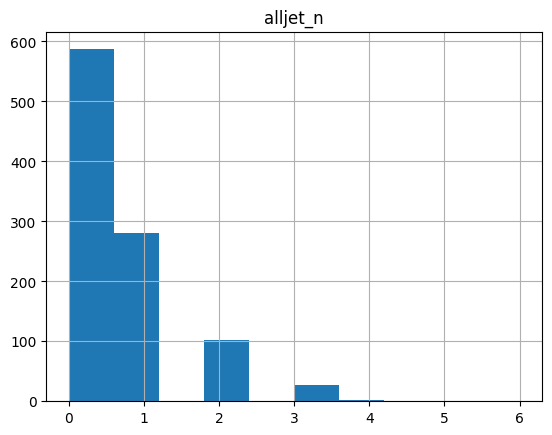

In [4]:
#In my notebook, had to run this cell twice to get the histograms to display...
df_Zmumu.hist()

array([[<AxesSubplot: title={'center': 'alljet_n'}>]], dtype=object)

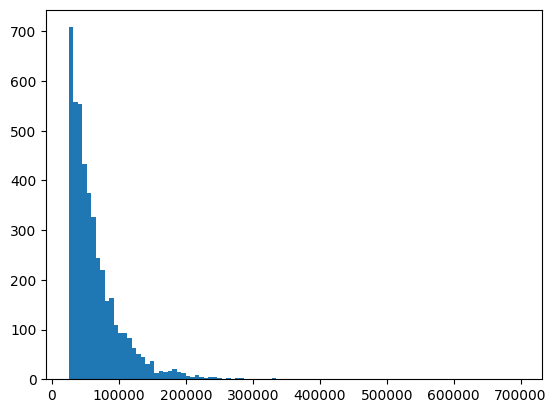

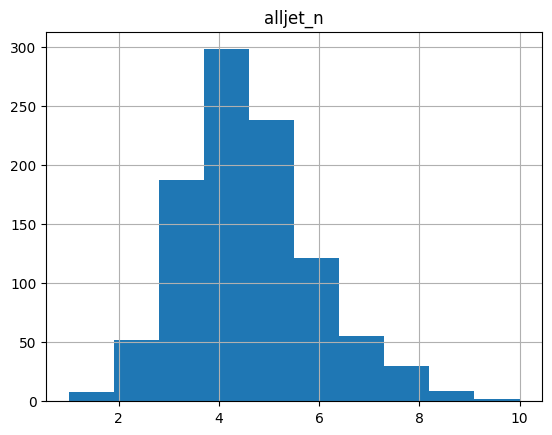

In [19]:
miniTreeTTbar = uproot.open("http://opendata.atlas.cern/release/samples/MC/mc_117049.ttbar_had.root")["mini"]
df_ttbar = miniTreeTTbar.arrays(["alljet_n","jet_pt"],library='pd',entry_stop=1000)
#jet_pt is an "awkward array" (i.e of variable size)
#so we have to use this procedure to flatten it to a 1-D array that 
#the hist function would use.
jet_pt = df_ttbar['jet_pt']
import awkward, matplotlib.pylab as plt
jet_ptHist = plt.hist(awkward.flatten(jet_pt),bins=100)
#Other variable types can be histogrammed directly using the pandas array
df_ttbar.hist("alljet_n",bins=10)

In [ ]:
#Task 2
#Try making some histograms of other quantities in the open data.
#Can you reproduce plots we saw in earlier Lectures with .../Lecture1/tree2.root using uproot and matplotlib?

In [ ]:
df_Zmumu=df_Zmumu.assign(signal=1)
df_ttbar=df_ttbar.assign(signal=0)
df_list = [df_Zmumu,df_ttbar]
import pandas
df_all = pandas.concat(df_list)
df_all

In [ ]:
df_all.hist("jet_pt",bins=100,range=[0,200000])

In [ ]:
df_all.hist("signal")

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
model = Sequential()
model.add(Dense(12,input_dim=2,activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
dataset = df_all.values
X = dataset[:,0:2]
Y = dataset[:,2]
X

In [ ]:
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
model.fit(X,Y,epochs=1,batch_size=10)

In [ ]:
scores = model.evaluate(X,Y)

In [ ]:
print("\n%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))

In [ ]:
predictions = model.predict(X)
for i in range(5000):
	print('Data of %s was predicted to be %d (and expected to be %d)' % (X[i].tolist(), predictions[i], Y[i]))


In [ ]:
#Task 3
#Try using different variables and options and see if you can get something working better
#You may need to reset and clear the notebook to get the below to work - some of the above code seems to interfere

In [1]:
from ROOT import TMVA,TFile
#Create a DataLoader object and add signal and backgrond TTree to it
dataLoader = TMVA.DataLoader("dataset")
#We use a ROOT file with both signal and background trees - these correspond to signal and background classified
#calorimeter clusters
myFile = TFile.Open("MVATree_FirstEvent_0_LastEvent_10000.root")
signalTree = myFile.Get("signal;1")
backgroundTree = myFile.Get("background;1")
dataLoader.AddBackgroundTree(backgroundTree)
dataLoader.AddSignalTree(signalTree)
#Choose some variables to use in our classifier (BDT, NN etc)
dataLoader.AddVariable("emFracEnhanced",'F')
#dataLoader.AddVariable("emFracEnhanced",'F')
dataLoader.AddVariable("eng_frac_core",'F')
dataLoader.AddVariable("centerLambda",'F')
outputFile = TFile("model.root","RECREATE")
classification = TMVA.Experimental.Classification(dataLoader,outputFile,"Jobs=1")
classification.BookMethod(TMVA.Types.kBDT, "BDTG", "!H:!V:NTrees=2000:MinNodeSize=2.5%:BoostType=Grad:Shrinkage=0.10:"
                                             "UseBaggedBoost:BaggedSampleFraction=0.5:nCuts=20:MaxDepth=2")
#Restrict how many events we use for testing and training (const TCut &cut, Int_t NsigTrain, Int_t NbkgTrain, 
#Int_t NsigTest, Int_t NbkgTest)
dataLoader.PrepareTrainingAndTestTree("",100,100,100,100)
classification.Evaluate()
outputFile.Close()

Welcome to JupyROOT 6.26/06
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree background of type Background with 1137 events
DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree signal of type Signal with 961 events
<HEADER>                          : Loading booked method: BDT BDTG
                         : 
                         : the option NegWeightTreatment=InverseBoostNegWeights does not exist for BoostType=Grad
                         : --> change to new default NegWeightTreatment=Pray
                         : Rebuilding Dataset dataset
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree background
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree signal
<HEADER> DataSetFactory           : 

0%, time left: unknown
6%, time left: 0 sec
12%, time left: 0 sec
18%, time left: 0 sec
25%, time left: 0 sec
31%, time left: 0 sec
37%, time left: 0 sec
43%, time left: 0 sec
50%, time left: 0 sec
56%, time left: 0 sec
62%, time left: 0 sec
68%, time left: 0 sec
75%, time left: 0 sec
81%, time left: 0 sec
87%, time left: 0 sec
93%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time 

In [ ]:
#Get a vector of results (of size 1 in our case because we only trained one classifier)
results = classification.GetResults()
#Get a ROC graph and draw it
BDT_ROC_Graph = results[0].GetROCGraph()
from ROOT import TCanvas
canPython = TCanvas()
BDT_ROC_Graph.Draw()
canPython.Draw()